In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.special import jn  # Funciones de Bessel
from scipy import signal

# Parámetros del sistema
fs = 100000  # Frecuencia de muestreo (Hz)
T = 1      # Duración de la simulación (segundos)
t = np.arange(0, T, 1/fs)  # Vector de tiempo
N = len(t)   # Número de muestras

# Parámetros de la señal modulante (mensaje)
fm = 500    # Frecuencia de la señal modulante (Hz)
Am = 1       # Amplitud de la señal modulante

# Parámetros de la portadora
fc = 10000   # Frecuencia de la portadora (Hz)
Ac = 1       # Amplitud de la portadora
deltaF = 2000
# Índice de modulación (beta)
beta = deltaF / fm
print("El valor de Beta es:",beta)

# 1. Generar señal modulante (mensaje)
m_t = Am * np.sin(2 * np.pi * fm * t)

# 2. Generar señal FM
# Señal FM
fm_t = Ac * np.cos(2 * np.pi * fc * t + beta * np.sin(2 * np.pi * fm * t))

# 3. Análisis espectral de la señal original
f = np.linspace(-fs/2, fs/2, N)  # Vector de frecuencias

# Calcular FFT
fm_f = fftshift(fft(fm_t)) / N
P_espectral_orig = np.abs(fm_f)**2  # Densidad espectral de potencia

# 4. Calcular bandas laterales con funciones de Bessel
# Frecuencias de las bandas laterales
if beta < 2:
    n_max = 2   # solo portadora y primer par de laterales
else:
    n_max = int(np.ceil(beta + 3))

bandas = fc + np.arange(-n_max, n_max+1) * fm

# Calcular potencias teóricas usando funciones de Bessel
P_teorica = np.array([(Ac**2/2) * (jn(n, beta)**2) for n in range(-n_max, n_max+1)])
P_total_teorica = np.sum(P_teorica)

# Ajustar criterio para considerar una banda lateral significativa
umbral = 0.02 * P_total_teorica  # Más estricto
index_significativas = np.where(P_teorica > umbral)
bandas_significativas = bandas[index_significativas]
P_significativas = P_teorica[index_significativas]

# 5. Definir el canal con respuesta en frecuencia no plana
# Crear un vector de frecuencias para la respuesta en frecuencia
f_response = np.linspace(-fs/2, fs/2, N)

# CORRECCIÓN: Utilizar un enfoque diferente para crear la respuesta en frecuencia
response = np.ones(N)

# Determinar los índices correspondientes a las bandas laterales
band_width = 10000  # Ancho de banda total a afectar (Hz)
band_radius = band_width / 2

# Crear respuesta en frecuencia con variación más pronunciada
for i, freq in enumerate(f_response):
    # Aplicar ganancia variable alrededor de fc (positivo)
    if abs(freq - fc) < band_radius:
        # Usar coseno para tener un "valle" más pronunciado en bandas laterales altas
        response[i] = 0.8 * np.cos((freq - fc) * np.pi / band_radius) + 0.7
    # Aplicar ganancia variable alrededor de -fc (negativo)
    elif abs(freq + fc) < band_radius:
        response[i] = 0.8 * np.cos((freq + fc) * np.pi / band_radius) + 0.7

# 6. Aplicar ruido blanco gaussiano
SNR_dB = 30  # Relación señal-ruido en dB
SNR_lin = 10**(SNR_dB/10)
signal_power = np.mean(fm_t**2)
noise_power = signal_power / SNR_lin
noise = np.sqrt(noise_power) * np.random.normal(0, 1, N)

# 7. Señal en el canal: aplicar la respuesta no plana y añadir ruido
# CORRECCIÓN: Aplicar correctamente la respuesta en frecuencia
fm_f_abs = fftshift(fft(fm_t))
fm_f_filtered = fm_f_abs * response  # Aplicar respuesta directamente
fm_t_filtered = np.real(ifft(ifftshift(fm_f_filtered)))  # Volver al dominio del tiempo

# Añadir ruido
fm_t_channel = fm_t_filtered + noise

# 8. Calcular el espectro de la señal después del canal
fm_f_output = fftshift(fft(fm_t_channel)) / N
P_espectral_output = np.abs(fm_f_output)**2

# 9. Calcular las potencias de las bandas laterales (entrada y salida)
P_bandas_entrada = []
P_bandas_salida = []

for banda in bandas:
    # Encontrar el índice más cercano a la frecuencia de la banda
    idx = np.argmin(np.abs(f - banda))

    # Para mayor precisión, usar una ventana alrededor de la frecuencia central
    window = 5
    start_idx = max(0, idx - window)
    end_idx = min(len(f) - 1, idx + window)

    # Calcular potencia en la banda (entrada)
    P_bandas_entrada.append(np.max(P_espectral_orig[start_idx:end_idx+1]))

    # Calcular potencia en la banda (salida)
    P_bandas_salida.append(np.max(P_espectral_output[start_idx:end_idx+1]))

P_bandas_entrada = np.array(P_bandas_entrada)
P_bandas_salida = np.array(P_bandas_salida)

# Normalización para comparación
P_bandas_entrada_norm = P_bandas_entrada / np.sum(P_bandas_entrada) * 100
P_bandas_salida_norm = P_bandas_salida / np.sum(P_bandas_salida) * 100

El valor de Beta es: 4.0


<function matplotlib.pyplot.show(close=None, block=None)>

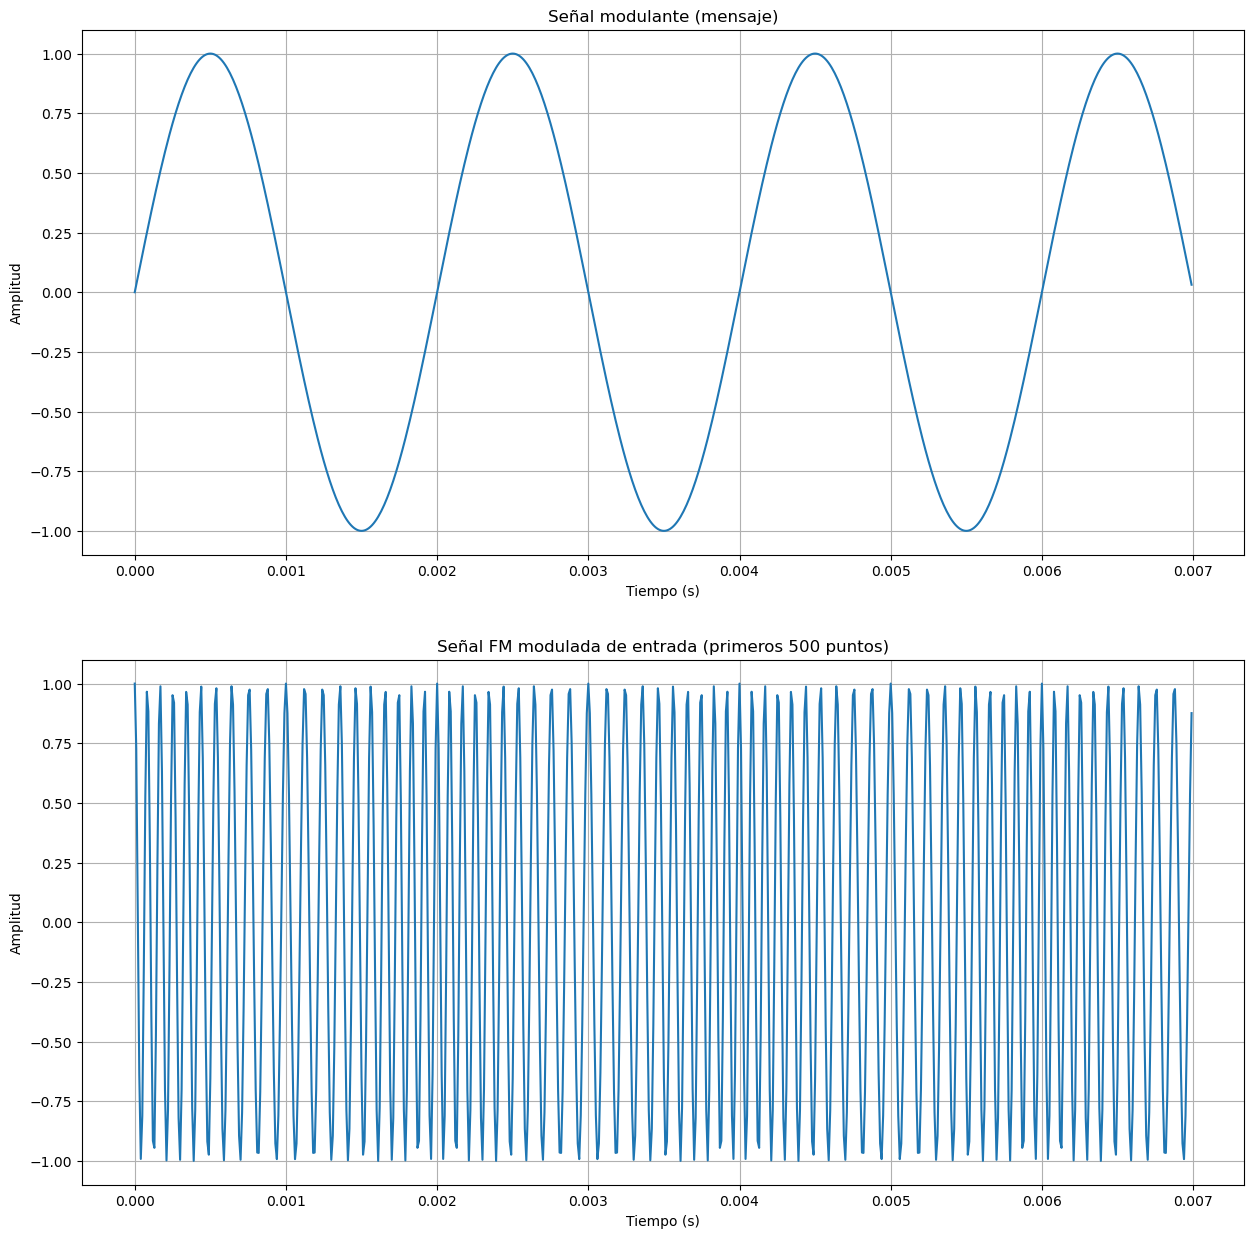

In [48]:
# 11. Visualización
plt.figure(figsize=(15, 15))
cantidadPuntos = 700
# Señal modulante
plt.subplot(2, 1, 1)
plt.plot(t[:cantidadPuntos], m_t[:cantidadPuntos])
plt.title('Señal modulante (mensaje)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)

# Señal modulada que ingresa al canal en el dominio del tiempo
plt.subplot(2, 1, 2)
plt.plot(t[:cantidadPuntos], fm_t[:cantidadPuntos])
plt.title('Señal FM modulada de entrada (primeros 500 puntos)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show

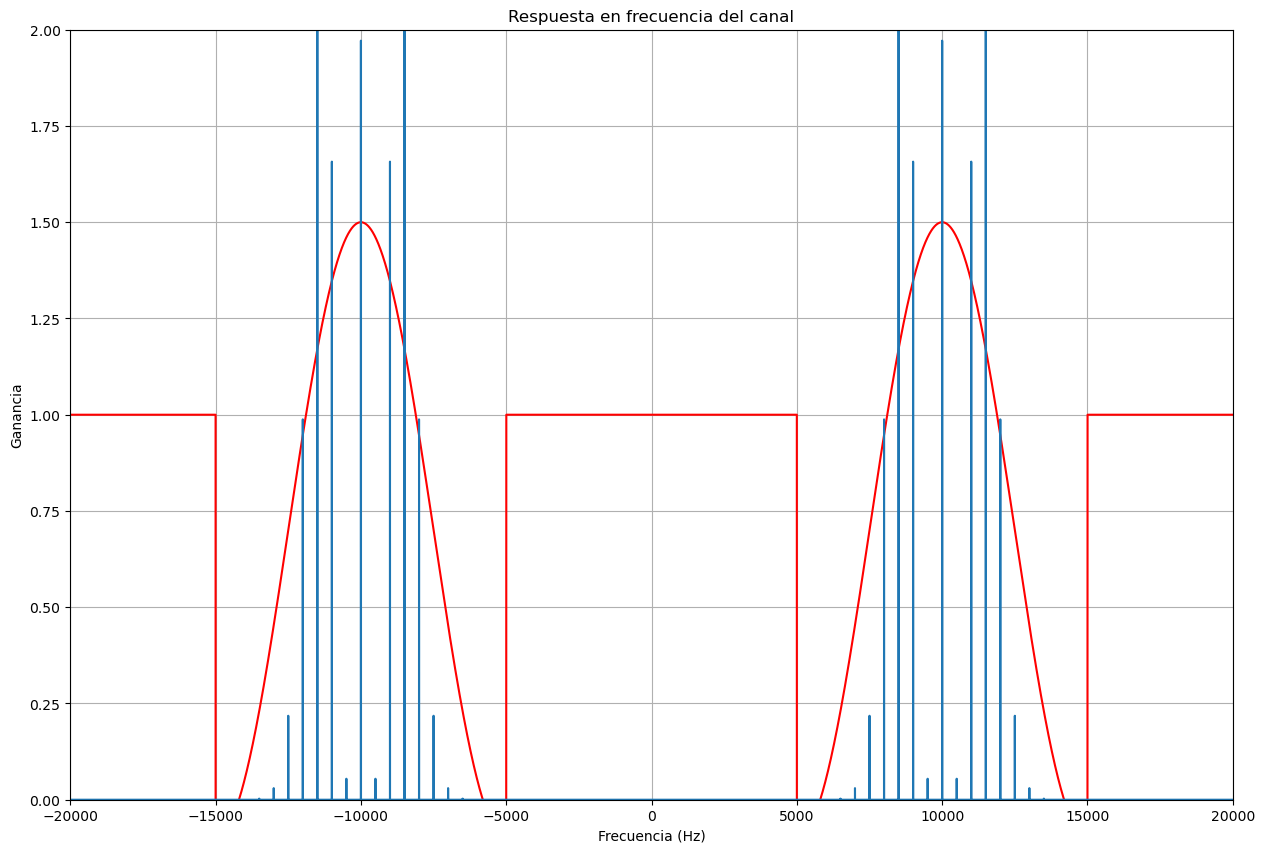

In [63]:
# Respuesta en frecuencia del canal
plt.figure(figsize=(15, 10))
plt.plot(f, response, color='r')
plt.plot(f, P_espectral_orig*50)
plt.xlim([-20000, 20000])
plt.ylim([0, 2.0])
plt.title('Respuesta en frecuencia del canal')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Ganancia')
plt.grid(True)

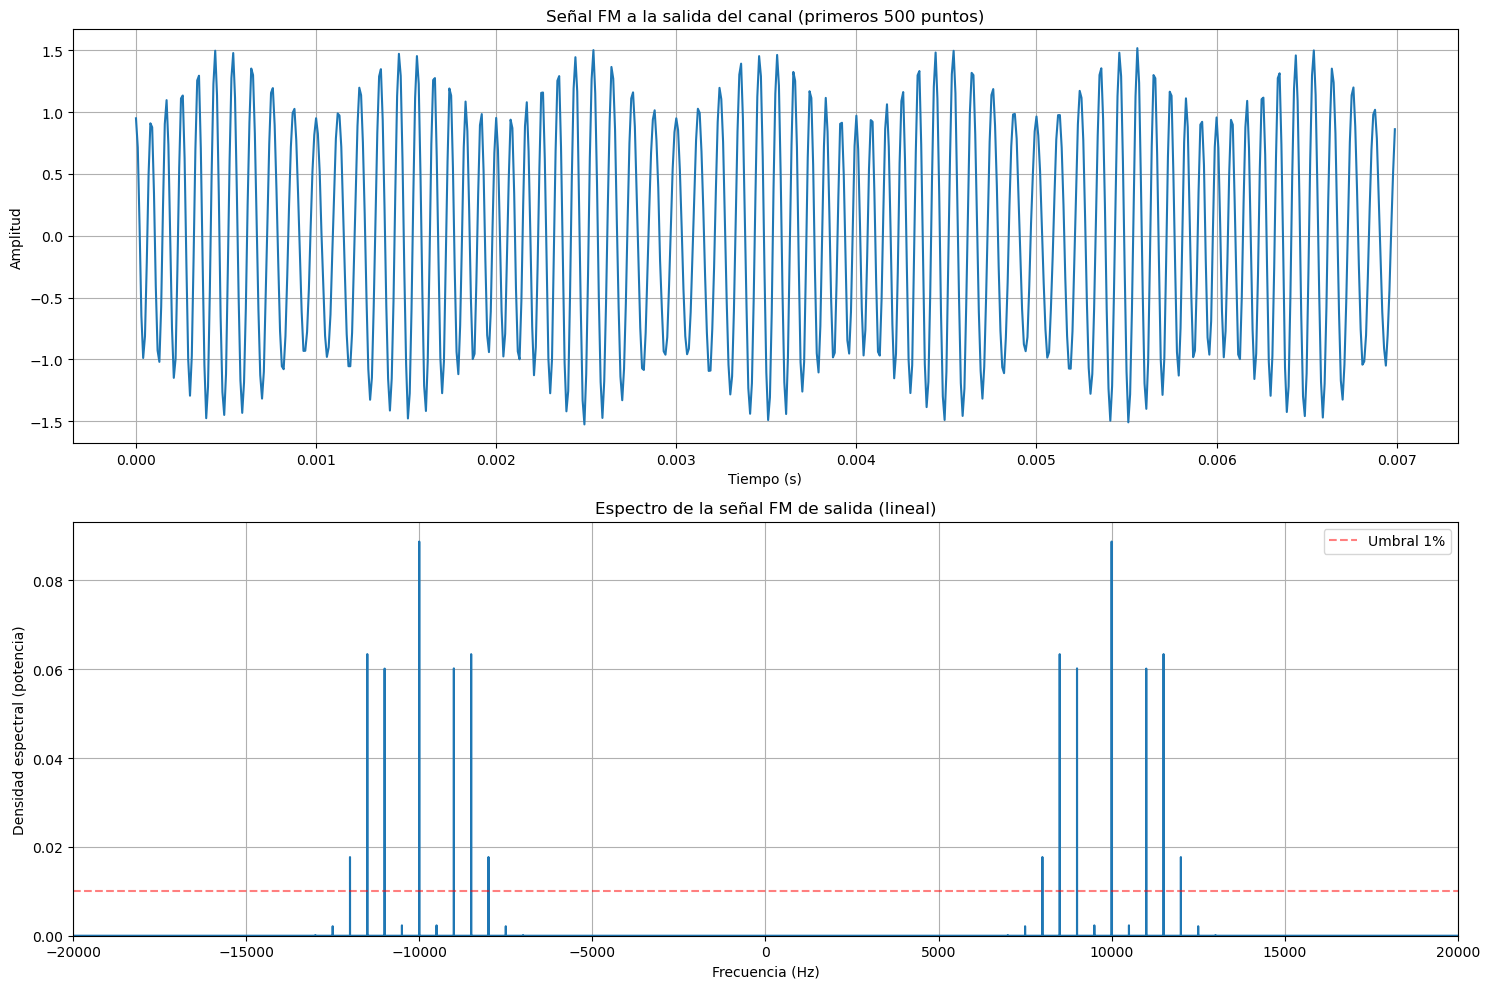

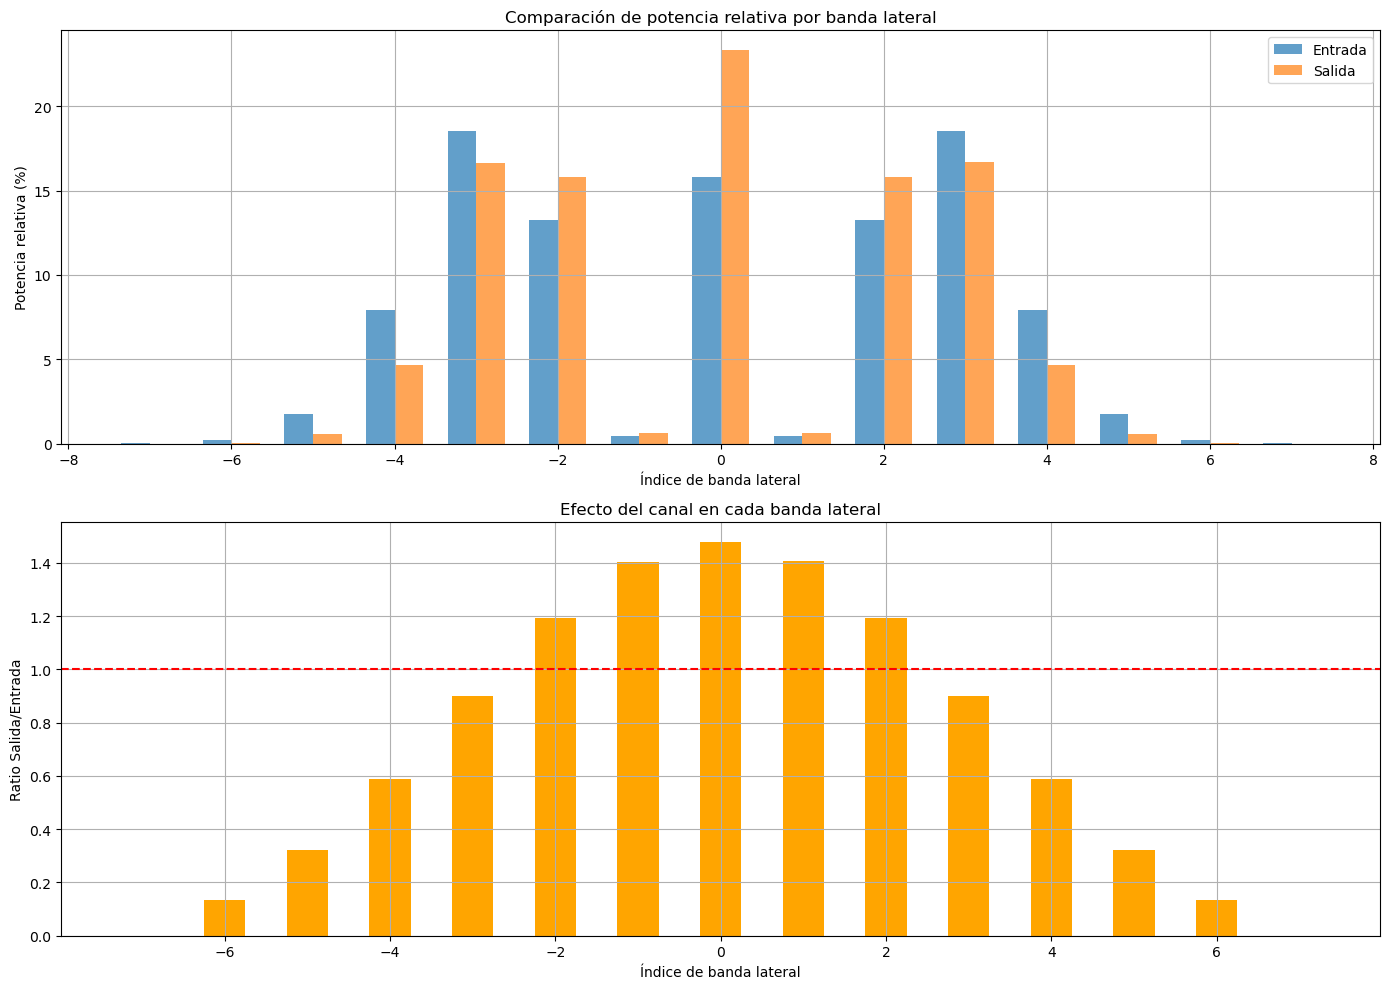


TABLA COMPARATIVA DE POTENCIAS DE BANDAS LATERALES
 Índice  | Frecuencia (Hz) | P. Teórica (%)  | P. Entrada (%)  |  P. Salida (%)  | Ratio S/E 
------------------------------------------------------------------------------------------
   -5    |     7500.00     |      1.745      |      1.745      |      0.560      |    0.32   
   -4    |     8000.00     |      7.904      |      7.904      |      4.657      |    0.59   
   -3    |     8500.00     |     18.505      |     18.505      |     16.660      |    0.90   
   -2    |     9000.00     |     13.259      |     13.259      |     15.819      |    1.19   
   -1    |     9500.00     |      0.436      |      0.436      |      0.613      |    0.00   
   0     |    10000.00     |     15.773      |     15.773      |     23.324      |    1.48   
   1     |    10500.00     |      0.436      |      0.436      |      0.613      |    0.00   
   2     |    11000.00     |     13.259      |     13.259      |     15.806      |    1.19   
   3     | 

In [64]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(t[:cantidadPuntos], fm_t_channel[:cantidadPuntos])
plt.title('Señal FM a la salida del canal (primeros 500 puntos)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)

# Espectro de la señal FM de salida en escala lineal
plt.subplot(2, 1, 2)
plt.plot(f, P_espectral_output)
plt.xlim([-20000, 20000])
plt.ylim(bottom=0)
plt.title('Espectro de la señal FM de salida (lineal)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral (potencia)')
plt.grid(True)

# Marcar las bandas laterales en la salida
# Línea horizontal roja punteada para el umbral del 1% (0.01)
plt.axhline(y=0.01, color='r', linestyle='--', alpha=0.5, label='Umbral 1%')
plt.legend()  # Muestra la leyenda

plt.tight_layout()
plt.show()

# 12. Gráfico comparativo de potencias relativas
plt.figure(figsize=(14, 10))

# Gráfico comparativo de potencias relativas entrada vs salida
plt.subplot(2, 1, 1)
width = 0.35
x = np.arange(-n_max, n_max+1)

plt.bar(x - width/2, P_bandas_entrada_norm, width, label='Entrada', alpha=0.7)
plt.bar(x + width/2, P_bandas_salida_norm, width, label='Salida', alpha=0.7)

plt.xlabel('Índice de banda lateral')
plt.ylabel('Potencia relativa (%)')
plt.title('Comparación de potencia relativa por banda lateral')
plt.grid(True)
plt.legend()

# Gráfico del ratio salida/entrada para ver el efecto del canal
plt.subplot(2, 1, 2)
ratio = np.zeros_like(P_bandas_entrada_norm)
for i in range(len(P_bandas_entrada_norm)):
    if P_bandas_entrada_norm[i] > 0.1:  # Evitar divisiones por casi cero
        ratio[i] = P_bandas_salida_norm[i] / P_bandas_entrada_norm[i]
    else:
        ratio[i] = 0

plt.bar(x, ratio, width=0.5, color='orange')
plt.axhline(y=1.0, color='r', linestyle='--')
plt.xlabel('Índice de banda lateral')
plt.ylabel('Ratio Salida/Entrada')
plt.title('Efecto del canal en cada banda lateral')
plt.grid(True)

plt.tight_layout()
plt.show()

# 13. Crear tabla de comparación
print("\nTABLA COMPARATIVA DE POTENCIAS DE BANDAS LATERALES")
print("="*90)
print(f"{'Índice':^8} | {'Frecuencia (Hz)':^15} | {'P. Teórica (%)':^15} | {'P. Entrada (%)':^15} | {'P. Salida (%)':^15} | {'Ratio S/E':^10}")
print("-"*90)

for i in range(len(bandas)):
    idx = i - n_max  # Índice de la banda lateral
    p_teorica = P_teorica[i]/P_total_teorica*100
    p_in = P_bandas_entrada_norm[i]
    p_out = P_bandas_salida_norm[i]

    # Solo mostrar bandas significativas (teóricas o medidas)
    if p_teorica > 0.5 or p_in > 0.5 or p_out > 0.5:
        ratio = p_out / p_in if p_in > 0.5 else 0
        print(f"{idx:^8} | {bandas[i]:^15.2f} | {p_teorica:^15.3f} | {p_in:^15.3f} | {p_out:^15.3f} | {ratio:^10.2f}")

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(f, P_espectral_orig)
plt.xlim([-20000, 20000])
plt.ylim(bottom=0)
plt.title('Espectro de la señal FM de entrada (lineal)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Densidad espectral (potencia)')
plt.grid(True)

# Línea horizontal roja punteada para el umbral del 1% (0.01)
plt.axhline(y=0.01, color='r', linestyle='--', alpha=0.5, label='Umbral 1%')
plt.legend()  # Muestra la leyenda
plt.show()